In [1]:
import pickle
import numpy as np

# Replace 'your_file.dat' with the path to your .dat file
file_path = '/home/mohan/Downloads/data_preprocessed_python/s01.dat'

# Open the file in binary read mode
with open(file_path, 'rb') as file:
    # Load the data using pickle
    data = pickle.load(file,encoding='latin1')

# Now, 'data' contains the data from the .dat file
array = np.array(data)

In [ ]:
# removing the last 8 channels form the data as it contains noise in them. 

# Method 1: Using Fast Fourier Transformation to train the signals. 

In [ ]:
### steps for the transformation. 

In [30]:
channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31]
all_channel = np.arange(32) 
band = [4,8,12,30,45] #4 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
subjectList = ['01']

In [50]:
all_channel

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
# install a module called pyeeg

In [8]:
!pip install git+https://github.com/forrestbao/pyeeg.git

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-vxiw4kc3
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-vxiw4kc3
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28113 sha256=e4e0e4b87f3b4ad7525cd2c4ea88dcf1b449e943276f8f6118013be2abb6c188
  Stored in directory: /tmp/pip-ephem-wheel-cache-d9xp23k3/wheels/e8/b8/db/0eeab6358ba1fb211a13fbc2a68d0d73f8382830bfcf5cc99c
Successfully built pyeeg


In [9]:
import numpy as np
import pickle
import pyeeg as pe
import matplotlib.pyplot as plt

## Here's the summary of what the FFT does.

This function, named `FFT_Processing`, is designed to process EEG data using Fast Fourier Transform (FFT) and create a dataset for machine learning analysis.


1. **Windowed FFT Analysis:**
   - It performs FFT analysis on windowed segments of the EEG data.
   - The window size and step size are specified by the `window_size` and `step_size` parameters.
   - For each specified EEG channel (`channel`), it extracts a segment of data, applies FFT to obtain power spectral density in specified frequency bands (`band`), and flattens the result into a 1D array.
   - This results in a feature vector (`meta_data`) for each time window.

2. **Create Meta-Data Array:**
   - It creates a meta-data array (`meta_array`) that contains the feature vector (`meta_data`) and the corresponding labels.
   - This array represents the features and labels for a specific time window within a trial.

3. **Data Collection:**
   - The meta-data arrays for all time windows and trials are collected into a list (`meta`).

4. **Convert and Save Data:**
   - The list of meta-data arrays is converted into a NumPy array (`meta`) and saved as a binary `.npy` file.
   - The saved file is named based on the subject identifier.

In summary, the function processes EEG data from a subject, performs windowed FFT analysis to extract features, and creates a dataset suitable for machine learning analysis. The resulting dataset can be used to train and evaluate machine learning models for tasks such as classification.

In [48]:
def FFT_Processing (sub, channel, band, window_size, step_size, sample_rate):
    '''
    arguments:  string subject
                list channel indice
                list band
                int window size for FFT
                int step size for FFT
                int sample rate for FFT
    return:     void
    '''
    meta = []
    with open("/home/mohan/Downloads/data_preprocessed_python/s" + sub + '.dat', 'rb') as file:

        subject = pickle.load(file, encoding='latin1') #resolve the python 2 data problem by encoding : latin1

        for i in range (0,40):
            # loop over 0-39 trails
            data = subject["data"][i]
            labels = subject["labels"][i]
            start = 0;

            while start + window_size < data.shape[1]:
                meta_array = []
                meta_data = [] #meta vector for analysis
                for j in channel:
                    X = data[j][start : start + window_size] #Slice raw data over 2 sec, at interval of 0.125 sec
                    Y = pe.bin_power(X, band, sample_rate) #FFT over 2 sec of channel j, in seq of theta, alpha, low beta, high beta, gamma
                    meta_data = meta_data + list(Y[0])

                meta_array.append(np.array(meta_data))
                meta_array.append(labels)

                meta.append(np.array(meta_array,dtype=object))
                start = start + step_size

        meta = np.array(meta)
        np.save('/home/mohan/Downloads/data_preprocessed_python/s' + sub, meta, allow_pickle=True, fix_imports=True)


In [49]:
for subjects in subjectList:
    FFT_Processing (subjects, all_channel, band, window_size, step_size, sample_rate)

In [47]:
data_training = []
label_training = []
data_testing = []
label_testing = []

for subjects in subjectList:

    with open('/home/mohan/Downloads/data_preprocessed_python/s' + subjects + '.npy', 'rb') as file:
      sub = np.load(file,allow_pickle=True)
      for i in range (0,sub.shape[0]):
        if i % 5 == 0:
          data_testing.append(sub[i][0])
          label_testing.append(sub[i][1])
        else:
          data_training.append(sub[i][0])
          label_training.append(sub[i][1])

np.save('./data_training', np.array(data_training), allow_pickle=True, fix_imports=True)
np.save('./label_training', np.array(label_training), allow_pickle=True, fix_imports=True)
print("training dataset:", np.array(data_training).shape, np.array(label_training).shape)

np.save('./data_testing', np.array(data_testing), allow_pickle=True, fix_imports=True)
np.save('./label_testing', np.array(label_testing), allow_pickle=True, fix_imports=True)
print("testing dataset:", np.array(data_testing).shape, np.array(label_testing).shape)


training dataset: (15616, 56) (15616, 4)
testing dataset: (3904, 56) (3904, 4)


### ploting the 4 bands after performing the fft transformation.

In [ ]:
# performing fft on a single channel of the subject. 

In [64]:
signal = data['data']
signal[0].shape
eeg_data = signal[0]

In [65]:
channel_1 = eeg_data[0,:]
channel_1

array([ 0.94823168,  1.65333533,  3.01372577, ..., -2.82648937,
       -4.47722969, -3.67692812])

In [66]:
!pip install git+https://github.com/forrestbao/pyeeg.git
import numpy as np
import pickle
import pyeeg as pe  # Ensure pyeeg is installed

def FFT_Processing_Single_Channel(data, band, window_size, step_size, sample_rate):
    '''
    arguments:  numpy array data (single channel EEG data)
                list band (frequency band for FFT)
                int window_size (window size for FFT)
                int step_size (step size for FFT)
                int sample_rate (sample rate for FFT)
    return:     numpy array (processed data)
    '''
    meta = []
    start = 0

    while start + window_size < len(data):
        meta_data = []  # meta vector for analysis
        X = data[start: start + window_size]  # Slice raw data
        Y = pe.bin_power(X, band, sample_rate)  # FFT over the window of data

        meta_data = meta_data + list(Y[0])
        meta.append(np.array(meta_data))
        start = start + step_size

    meta = np.array(meta)
    return meta

# Example usage

# data = your_single_channel_data  # Replace with your single channel data
# band = [theta_band, alpha_band, etc.]  # Define your frequency bands
# window_size = ...  # Define your window size
# step_size = ...  # Define your step size
# sample_rate = 128  # Example sample rate



#channel = [1,2,3,4,6,11,13,17,19,20,21,25,29,31] #14 Channels chosen to fit Emotiv Epoch+
#band = [4,8,12,16,25,45] #5 bands
all_channel = np.arange(32)
band = [4,8,12,30,45] #4 bands
window_size = 256 #Averaging band power of 2 sec
step_size = 16 #Each 0.125 sec update once
sample_rate = 128 #Sampling rate of 128 Hz
data = channel_1



processed_data = FFT_Processing_Single_Channel(data, band, window_size, step_size, sample_rate)


  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-zwqrxp6r
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-zwqrxp6r
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done


In [ ]:
# FFT bands in time series. 

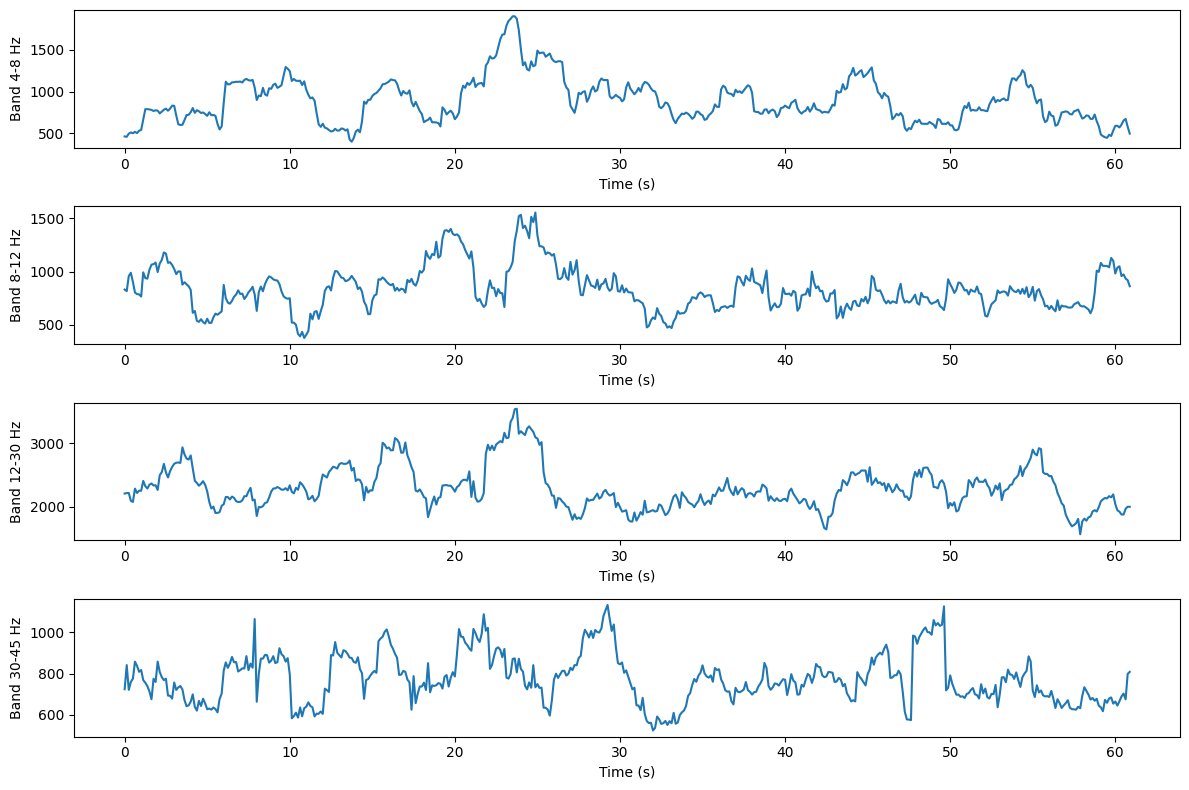

In [67]:
import matplotlib.pyplot as plt

def plot_fft_bands(processed_data, band, step_size, sample_rate):
    '''
    Plot each frequency band's power over time.

    arguments:
    processed_data -- numpy array from FFT processing
    band -- list of frequency bands
    step_size -- step size used in FFT processing
    sample_rate -- sample rate of the data
    '''
    num_bands = len(band) - 1
    time = np.arange(processed_data.shape[0]) * (step_size / sample_rate)

    plt.figure(figsize=(12, 8))

    for i in range(num_bands):
        plt.subplot(num_bands, 1, i + 1)
        plt.plot(time, processed_data[:, i])
        plt.ylabel(f'Band {band[i]}-{band[i+1]} Hz')
        plt.xlabel('Time (s)')

    plt.tight_layout()
    plt.show()

# Example usage
plot_fft_bands(processed_data, band, step_size, sample_rate)


### plotting the frequency bands in the frequency format. 

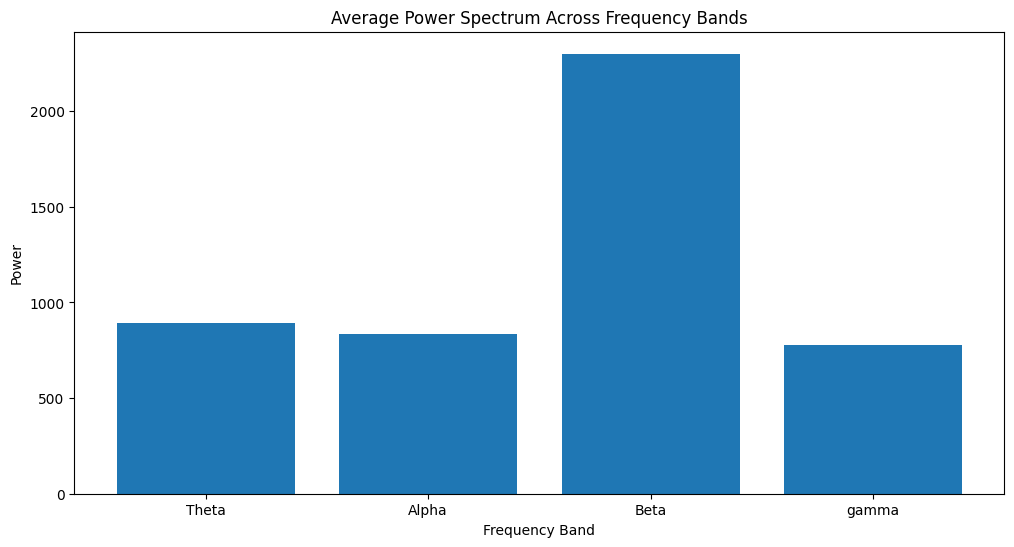

In [68]:
import matplotlib.pyplot as plt

def plot_fft_data(processed_data, band_labels):
    '''
    Plot the FFT processed data.

    arguments:
    processed_data -- numpy array from FFT processing
    band_labels -- list of strings representing the names of the frequency bands
    '''

    # Averaging the processed data across windows
    avg_processed_data = np.mean(processed_data, axis=0)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(band_labels, avg_processed_data)
    plt.xlabel('Frequency Band')
    plt.ylabel('Power')
    plt.title('Average Power Spectrum Across Frequency Bands')
    plt.show()

# Example usage
band_labels = ['Theta', 'Alpha', 'Beta', 'gamma']  # Replace with your frequency band names
plot_fft_data(processed_data, band_labels)


# Method 2 - standard scaling with mean 0 and standard deviation 1 

In [ ]:
- preparing the data. 

In [54]:
def convert_transpose(subject_data):
    dataset = []
    for i in range(subject_data.shape[0]):
        dataset.append(subject_data[i].T)
    dataset = np.array(dataset)
    return dataset

In [55]:
import pickle
all_sub_data = []
subjects_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32']
for sub in subjects_list:
    path = "/home/mohan/Downloads/data_preprocessed_python/s"+sub+".dat"
    x = pickle.load(open(path, 'rb'), encoding = 'latin1')
    sub_data = x['data']
    sub_eeg = sub_data[:, :32, :128*60]
    dataset = convert_transpose(sub_eeg)
    all_sub_data.extend(dataset)
all_sub_data = np.array(all_sub_data)

In [56]:
all_sub_data.shape

(1280, 7680, 32)

In [57]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [58]:
for instance in range(all_sub_data.shape[0]):
  all_sub_data[instance] = StandardScaler().fit_transform(all_sub_data[instance])